# Word model

In [1]:
import numpy as np
from word_dataset import WordDataset
from word_model import WordRNN

## Dataset

In [3]:
%%time
dataset = WordDataset()
dataset.load('data/dostoevsky.txt')  # dostoevsky.txt  anna.txt
model_path = 'models/word/dostoevsky-001/'

CPU times: user 52.6 s, sys: 196 ms, total: 52.8 s
Wall time: 52.8 s


## Build

In [6]:
%%time
num_layers  = 2
num_units   = 256
grad_clip   = 5.0

model = WordRNN(
    num_classes = dataset.num_tokens)

model.build(
    emb_size   = 300,
    num_units  = num_units, 
    num_layers = num_layers, 
    grad_clip  = grad_clip)

CPU times: user 2.65 s, sys: 48 ms, total: 2.7 s
Wall time: 2.75 s


## Train

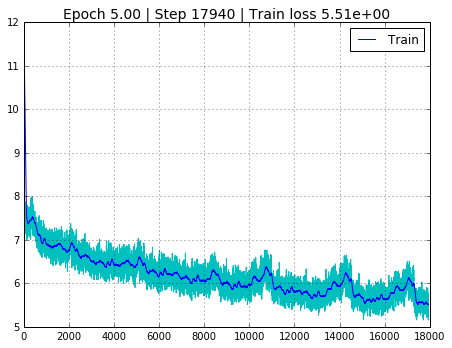

In [ ]:
%%time
model.train(
    epochs        = 50, 
    batch_size    = 32, 
    seq_length    = 20,
    learning_rate = 1e-3, 
    keep_prob     = .5,
    mean_win      = 100,
    dataset       = dataset)
model.save(model_path)

## Test

In [44]:
primes = ['князь', 'настасья', 'рогожин', 'лебедев', 'аглая', 'генерал']
for prime in primes:
    print('-'*50)
    samp = model.sample(dataset, n_samples=100, top_n=15, prime=prime)
    samp = samp.replace(' .', '.').replace(' ,', ',').replace(' !', '!').replace(' ?', '?').replace(' :', ':')
    print(samp)    

--------------------------------------------------
князь, впрочем, не знаю, я был не знал, что вы, кажется, он уже никогда не не так бы не так и не знал. я вам и так говорил. это он не могла. — как, что я в самом деле и все? — и я думаю, он, кажется, и не могу, и я не видал ему с нами на его счет и в таком случае и с кем он вас и не знаю! я не могу. я, я, кажется, так и не так
--------------------------------------------------
настасья петрович, не отрываясь, как бы он в волнении. он стал было на него все это же в том и он еще и не было, но он все не мог говорить его, но он и все это так и очень не знал, как и даже до сих пор не мог. он так и не хотел ее, чтобы в своем смысле и даже очень очень хорошо, что я знал к ним и с нею и не мог ни малейшего этого, а потом в то время был как не то, чтобы, конечно
--------------------------------------------------
рогожин, что вы знаете, — проговорила я вдруг, вдруг как бы в состоянии. — ну, вот ты, батюшка, так ведь вы и теперь так так быть, что

## Restore

In [19]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/word/dostoevsky-001/


INFO:tensorflow:Restoring parameters from models/word/dostoevsky-001/
